In [1]:
import random
import math
import matplotlib.pyplot as plt
import torch

# Dataset

In [7]:
def random_sine(samples=50, max_amp=1, min_amp=0, max_freq=5, min_freq=0.2, freq_chaos=0.3, amp_chaos=0.1):
  phase = random.uniform(0, math.pi * 2)
  amp = random.uniform(min_amp, max_amp)
  offset = random.uniform(1-amp, amp-1)
  freq = random.uniform(min_freq, max_freq)
  phase_incr = 2 * freq * math.pi / samples
  output = []

  for _ in range(samples):
    phase += phase_incr
    output.append(math.sin(phase) * amp + offset)
    if random.random() < amp_chaos:
      amp = random.uniform(min_amp, max_amp)
      offset = random.uniform(1-amp, amp-1)
    if random.random() < freq_chaos:
      freq = random.uniform(min_freq, max_freq)
      phase_incr = 2 * freq * math.pi / samples

  return output

In [8]:
def random_nums(samples=50):
  return [random.random() for _ in range(samples)]

In [9]:
def permute_signal(signal, size_reduction = 3, max_pad = 5):
  # remove some points
  new_signal = list(signal)

  for i in range(size_reduction):
    point = random.randint(0, len(new_signal) - 1)
    del new_signal[point]

  # add interpolations
  for i in range(size_reduction):
    point = random.randint(1, len(new_signal) - 1)
    interp = (new_signal[point - 1] + new_signal[point]) / 2
    new_signal.insert(point, interp)

  # add noise
  for i in range(len(new_signal)):
    new_signal[i] += random.uniform(-0.05, 0.05)

  # add some zero padding in the beginning
  pad_num = random.randint(0, max_pad)
  padding = [0 for _ in range(pad_num)]
  new_signal = padding + new_signal[:len(new_signal) - pad_num]

  return new_signal
    

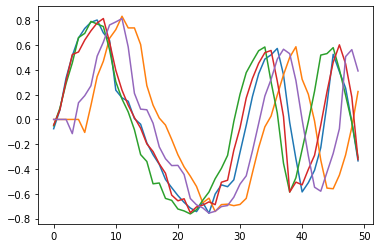

In [10]:
sequence = random_sine()
for _ in range(5):
  plt.plot(permute_signal(sequence))

In [11]:
def generate_data(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y


# MODEL

In [21]:
class LSTMMemory(torch.nn.Module):

  def __init__(self, hidden_size):
    super().__init__()

    self._hidden_state = None

    self.lstm = torch.nn.LSTM(
        input_size = 1,
        hidden_size = hidden_size,
        batch_first = True
    )

    self.linear = torch.nn.Linear(
            in_features=hidden_size,
            out_features=1
        )

  def forward(self, x):
    h = self.lstm(x)[0]

    return self.linear(h)

  def forward_live(self, x):
    if self._hidden_state:
      h, self._hidden_state = self.lstm(x, self._hidden_state)
    else:
      h, self._hidden_state = self.lstm(x)

    return self.linear(h)
  
  def reset_live(self):
    self._hidden_state = None


# TESTING

## Random nums -> random sine

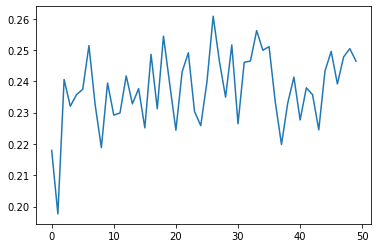

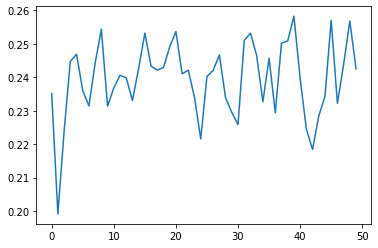

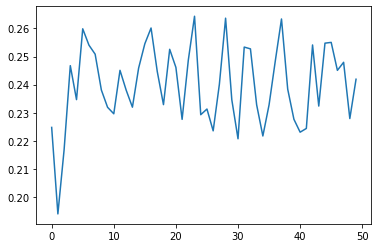

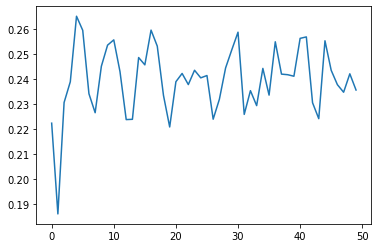

Predicted:  [[[0.22243604063987732], [0.18613207340240479], [0.23070524632930756], [0.2390046864748001], [0.2652207016944885], [0.2595900297164917], [0.2342222034931183], [0.2266218364238739], [0.24520674347877502], [0.25365176796913147], [0.2557680010795593], [0.24305638670921326], [0.22387269139289856], [0.2239835262298584], [0.24869635701179504], [0.24577361345291138], [0.259669691324234], [0.2532661557197571], [0.23355630040168762], [0.22092075645923615], [0.2390223741531372], [0.2423342764377594], [0.23788264393806458], [0.24361552298069], [0.24057015776634216], [0.2414989471435547], [0.22403143346309662], [0.23199686408042908], [0.24452842772006989], [0.25180381536483765], [0.2588360905647278], [0.22595487534999847], [0.23544083535671234], [0.22945727407932281], [0.2443518489599228], [0.23366454243659973], [0.25500038266181946], [0.24206607043743134], [0.24182891845703125], [0.24121922254562378], [0.25637418031692505], [0.25695154070854187], [0.2306189090013504], [0.2242395281791

In [ ]:
model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()

for i in range(1):
  X, y = generate_data()
  for j in range(50):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()


for _ in range(4):
  with torch.no_grad():
    test_X, test_y = generate_data()
    test_predicted_y = model(test_X)
  plt.figure()
  plt.plot(test_predicted_y.tolist()[0])
  plt.show()
plt.show()
print("Predicted: ", test_predicted_y.tolist())

## Random nums -> permuted random sine

In [ ]:
def generate_randnums_permutedsines(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y

INPUT:


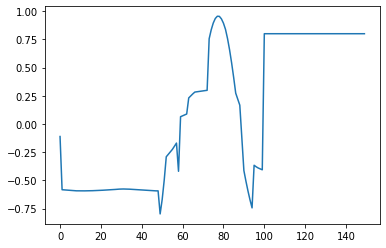

OUTPUT:


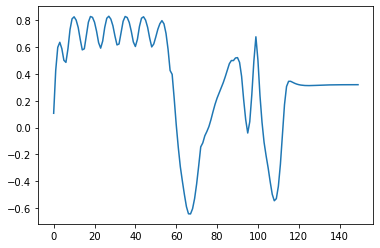

INPUT:


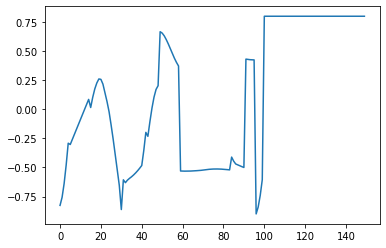

OUTPUT:


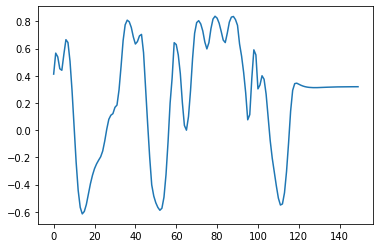

INPUT:


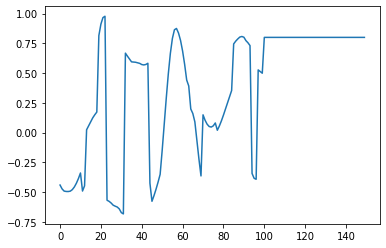

OUTPUT:


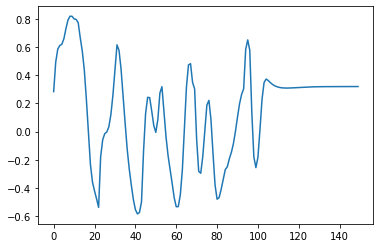

INPUT:


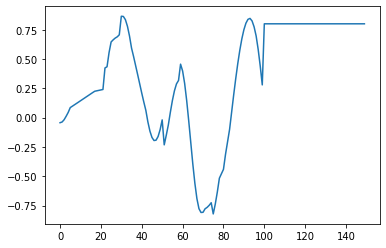

OUTPUT:


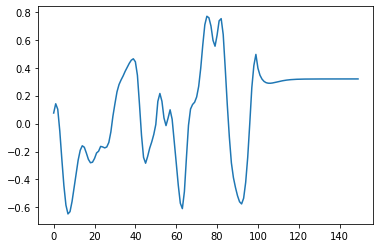

Predicted:  [[[0.07546819746494293], [0.14174950122833252], [0.10245181620121002], [-0.05382847785949707], [-0.25479477643966675], [-0.44335079193115234], [-0.5833310484886169], [-0.6464824676513672], [-0.6303345561027527], [-0.5573973059654236], [-0.45771560072898865], [-0.35412150621414185], [-0.2608436048030853], [-0.1912159025669098], [-0.15886518359184265], [-0.16945680975914001], [-0.2108078896999359], [-0.2561223804950714], [-0.28031906485557556], [-0.2766585648059845], [-0.24993214011192322], [-0.210442453622818], [-0.19753238558769226], [-0.16341450810432434], [-0.16716492176055908], [-0.17416217923164368], [-0.16734036803245544], [-0.13500556349754333], [-0.059741295874118805], [0.052592240273952484], [0.1426800638437271], [0.22710826992988586], [0.2795100212097168], [0.31230393052101135], [0.3409382402896881], [0.3740215599536896], [0.40325260162353516], [0.4307895600795746], [0.4535829722881317], [0.46353691816329956], [0.44223305583000183], [0.3457188904285431], [0.1391692

In [ ]:
model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = random_sine(50)
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1))
y_list = random_sine(50)
for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()


for _ in range(4):
  with torch.no_grad():
    test_X = torch.tensor((random_sine(100) + [0.8 for _ in range(50)])).reshape((1, 150, 1))
    test_predicted_y = model(test_X)
  print("INPUT:")
  plt.figure()
  plt.plot(test_X.tolist()[0])
  plt.show()
  print("OUTPUT:")
  plt.figure()
  plt.plot(test_predicted_y.tolist()[0])
  plt.show()
plt.show()
print("Predicted: ", test_predicted_y.tolist())

# Time since last note + velocity from Bonk

In [2]:
from sklearn import preprocessing

TIMES


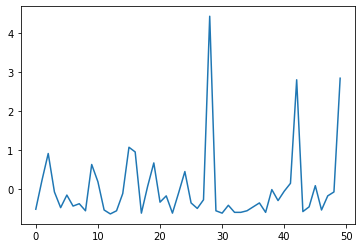

VELS


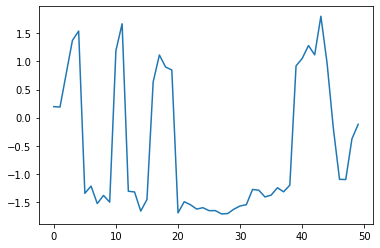

In [15]:
with open('/content/drive/MyDrive/rnn_improv/time_vel.txt') as f:
  txt = f.readlines()

data_pts = []
times = []
vels = []

for pt in txt:
  time, vel = pt.split(' ')
  time = float(time)
  vel = float(vel[:-2])
  data_pts.append([time, vel])
  times.append(time)
  vels.append(vel)

times = preprocessing.scale(times)
vels = preprocessing.scale(vels)

print("TIMES")
plt.figure()
plt.plot(times[:50])
plt.show()
print("VELS")
plt.figure()
plt.plot(vels[:50])
plt.show()

### Training with just velocity

INPUT:


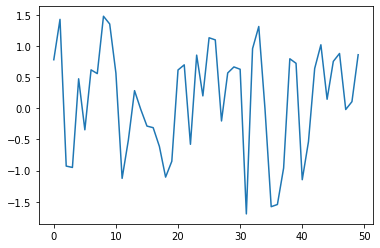

OUTPUT:


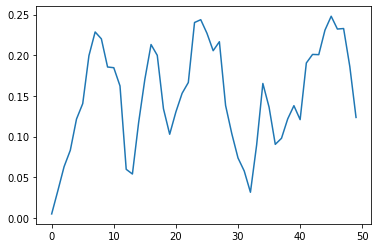

INPUT:


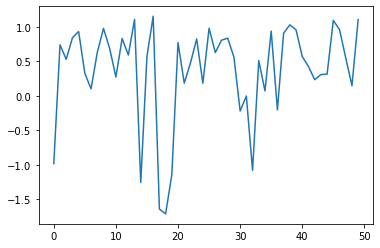

OUTPUT:


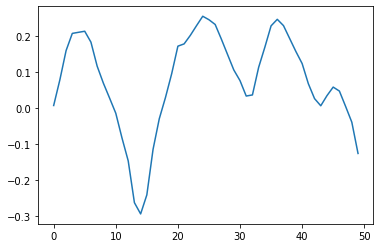

INPUT:


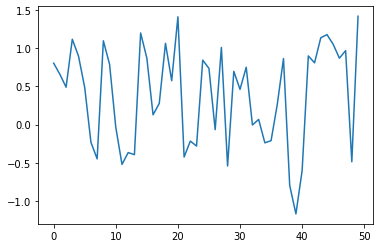

OUTPUT:


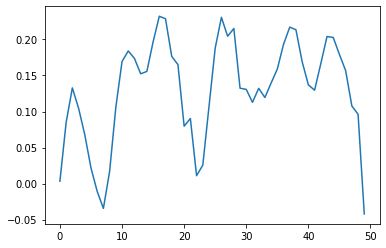

INPUT:


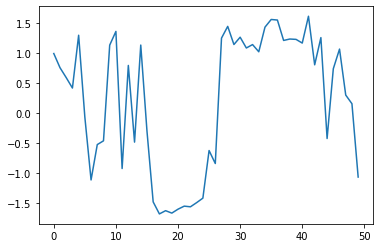

OUTPUT:


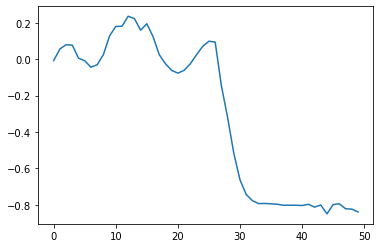

Predicted:  [[[-0.008173633366823196], [0.0553162582218647], [0.07903596758842468], [0.07680095732212067], [0.005029696971178055], [-0.009039636701345444], [-0.0447719469666481], [-0.031058955937623978], [0.024199116975069046], [0.12772996723651886], [0.17939922213554382], [0.18053200840950012], [0.23548322916030884], [0.22239074110984802], [0.1590052843093872], [0.19428902864456177], [0.12344419956207275], [0.02439631149172783], [-0.025508582592010498], [-0.06203160434961319], [-0.07703489065170288], [-0.06168653443455696], [-0.02551836520433426], [0.02350771799683571], [0.07044237852096558], [0.0982617735862732], [0.09364350140094757], [-0.1462416648864746], [-0.32025346159935], [-0.5169351100921631], [-0.6639719605445862], [-0.7441019415855408], [-0.7777546048164368], [-0.7939099669456482], [-0.7929015159606934], [-0.7951561808586121], [-0.7971116900444031], [-0.802966296672821], [-0.8025981783866882], [-0.8029676675796509], [-0.8043351769447327], [-0.7976985573768616], [-0.81312859

In [22]:
random.seed(42)
torch.manual_seed(42)
model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = vels[:50]
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1)).float()
y_list = random_sine(50)
for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()


for i in range(4):
  with torch.no_grad():
    test_X = torch.tensor(vels[(i + 1) * 50:(i + 2) * 50]).reshape((1, 50, 1)).float()
    test_predicted_y = model(test_X)
  print("INPUT:")
  plt.figure()
  plt.plot(test_X.tolist()[0])
  plt.show()
  print("OUTPUT:")
  plt.figure()
  plt.plot(test_predicted_y.tolist()[0])
  plt.show()
plt.show()
print("Predicted: ", test_predicted_y.tolist())

### Saving

In [26]:
torch.save(model, "/content/drive/MyDrive/rnn_improv/vel.pt")

# Testing for live usage

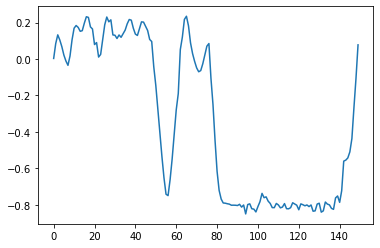

In [32]:
live_outputs = []
test_live_X = torch.tensor(vels[150:300]).reshape((1, 150, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(150):
    live_out = model.forward_live(test_live_X[:, i, :])
    live_outputs.append(live_out.item())

plt.plot(live_outputs)

